## Importing the relevant libraries

In [1]:
import torch, time
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


## Loading the dataset

In [3]:
df = pd.read_csv("/kaggle/input/forecasting-green-energy/train_IxoE5JN.csv",parse_dates=True,index_col='datetime',usecols=['datetime','energy'])
df.head()

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500


## Data Exploration

In [4]:
df.shape

(94992, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  93092 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [6]:
df.index

DatetimeIndex(['2008-03-01 00:00:00', '2008-03-01 01:00:00',
               '2008-03-01 02:00:00', '2008-03-01 03:00:00',
               '2008-03-01 04:00:00', '2008-03-01 05:00:00',
               '2008-03-01 06:00:00', '2008-03-01 07:00:00',
               '2008-03-01 08:00:00', '2008-03-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=94992, freq=None)

In [7]:
df.isna().sum()

energy    1900
dtype: int64

In [8]:
df = df.fillna(df.energy.mean(),axis=1)
df.isnull().sum()

energy    0
dtype: int64

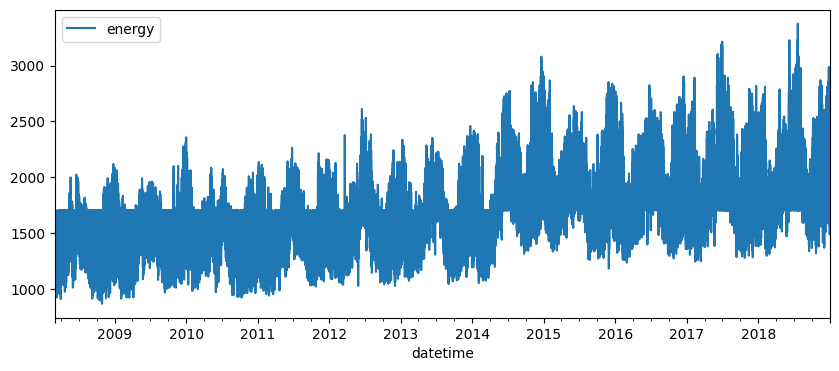

In [9]:
df.plot(figsize=(10,4));

In [10]:
y = df.energy.astype(float).values
y

array([1259.9855625, 1095.5415   , 1056.2475   , ..., 2365.9944   ,
       2342.9428   , 2180.2176   ])

## Dividing data into train and test sets

In [11]:
test_size = int(0.2*len(y))
train_set = y[:-test_size]
test_set = y[-test_size:]

In [12]:
train_set.shape, test_set.shape

((75994,), (18998,))

## Performing Min-Max scaling on train data

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [14]:
train_norm

array([[-0.64431156],
       [-0.79291752],
       [-0.82842699],
       ...,
       [-0.47034113],
       [-0.4331855 ],
       [-0.33020477]])

In [15]:
train_norm = torch.FloatTensor(train_norm).view(-1) # Flattening the output tensor
train_norm

tensor([-0.6443, -0.7929, -0.8284,  ..., -0.4703, -0.4332, -0.3302])

In [16]:
train_norm.shape

torch.Size([75994])

## Defining a custom function to segregate sequential data into batches

In [17]:
def divide_data_into_batches(input_sequence,window_length):
    outputs = []
    
    for i in range(len(input_sequence)-window_length):
        window = input_sequence[i:i+window_length]
        label = input_sequence[i+window_length:i+window_length+1]
        outputs.append((window,label))
    
    return outputs

In [18]:
train_df = divide_data_into_batches(train_norm,20)
train_df[:5]

[(tensor([-0.6443, -0.7929, -0.8284, -0.8479, -0.8555, -0.8487, -0.8008, -0.6879,
          -0.6139, -0.5911, -0.5739, -0.5639, -0.5533, -0.5510, -0.5309, -0.5242,
          -0.5242, -0.5318, -0.5551, -0.5806]),
  tensor([-0.5664])),
 (tensor([-0.7929, -0.8284, -0.8479, -0.8555, -0.8487, -0.8008, -0.6879, -0.6139,
          -0.5911, -0.5739, -0.5639, -0.5533, -0.5510, -0.5309, -0.5242, -0.5242,
          -0.5318, -0.5551, -0.5806, -0.5664]),
  tensor([-0.5554])),
 (tensor([-0.8284, -0.8479, -0.8555, -0.8487, -0.8008, -0.6879, -0.6139, -0.5911,
          -0.5739, -0.5639, -0.5533, -0.5510, -0.5309, -0.5242, -0.5242, -0.5318,
          -0.5551, -0.5806, -0.5664, -0.5554]),
  tensor([-0.5963])),
 (tensor([-0.8479, -0.8555, -0.8487, -0.8008, -0.6879, -0.6139, -0.5911, -0.5739,
          -0.5639, -0.5533, -0.5510, -0.5309, -0.5242, -0.5242, -0.5318, -0.5551,
          -0.5806, -0.5664, -0.5554, -0.5963]),
  tensor([-0.6579])),
 (tensor([-0.8555, -0.8487, -0.8008, -0.6879, -0.6139, -0.5911, 

## Defining the custom LSTM model architecture

In [19]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=256,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,output_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,sequence):
        lstm_output, self.hidden = self.lstm(sequence.view(len(sequence),1,-1),self.hidden)
        pred = self.linear(lstm_output.view(len(lstm_output),-1))
        return pred[-1]

In [20]:
torch.manual_seed(42)
model = LSTM().cuda()
model

LSTM(
  (lstm): LSTM(1, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
total_parameters = 0

for param in model.parameters():
    print(param.numel())
    total_parameters += param.numel()
    
print("Total parameters of LSTM model:", total_parameters)

1024
262144
1024
1024
256
1
Total parameters of LSTM model: 265473


In [22]:
criterion = nn.MSELoss()
optimizer = opt.Adam(params=model.parameters(),lr=0.001)

## Training model on train data

In [23]:
start_time = time.time()

epochs = 25

losses = []

for i in range(1,epochs+1):
    
    for sequence, y_train in train_df:
        sequence, y_train = sequence.cuda(), y_train.cuda()
        optimizer.zero_grad() # Reset the gradients to zero at each step
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),torch.zeros(1,1,model.hidden_size,device='cuda')) # Reset the LSTM model's hidden and cell states
        y_pred = model(sequence) # Make predictions
        loss = criterion(y_pred,y_train)
        losses.append(loss.item())
        loss.backward() # Perform backpropagation
        optimizer.step() # Update the weights and biases during each backprop step
    
    print(f"Epoch {i} -> Loss: {loss.item()}")
    
print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.0008620006265118718
Epoch 2 -> Loss: 0.0006506193894892931
Epoch 3 -> Loss: 0.0013005260843783617
Epoch 4 -> Loss: 0.0005761325010098517
Epoch 5 -> Loss: 0.000806712603662163
Epoch 6 -> Loss: 0.0005616828566417098
Epoch 7 -> Loss: 0.0004983394755981863
Epoch 8 -> Loss: 0.0003651303704828024
Epoch 9 -> Loss: 0.00041306341881863773
Epoch 10 -> Loss: 0.000606060610152781
Epoch 11 -> Loss: 0.0005245458451099694
Epoch 12 -> Loss: 0.00037362566217780113
Epoch 13 -> Loss: 0.0001891703432193026
Epoch 14 -> Loss: 1.1908095842727562e-07
Epoch 15 -> Loss: 0.00022229159367270768
Epoch 16 -> Loss: 3.34622964146547e-05
Epoch 17 -> Loss: 0.0001381874899379909
Epoch 18 -> Loss: 2.9995366276125424e-05
Epoch 19 -> Loss: 1.0178070624533575e-05
Epoch 20 -> Loss: 0.0004777151334565133
Epoch 21 -> Loss: 0.0012232521548867226
Epoch 22 -> Loss: 0.0014386993134394288
Epoch 23 -> Loss: 0.0010117292404174805
Epoch 24 -> Loss: 0.0012473749229684472
Epoch 25 -> Loss: 0.0015843309229239821
Total 

## Making predictions on test data

In [24]:
forecast = 24
window_size = 20

predictions = train_norm[-window_size:].tolist()

model.eval()

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),torch.zeros(1,1,model.hidden_size,device='cuda'))
        pred = model(seq).item()
        predictions.append(pred)

In [25]:
predictions[-24:]

[-0.251140296459198,
 -0.1986013650894165,
 -0.16598115861415863,
 -0.1437562108039856,
 -0.13345475494861603,
 -0.1354474425315857,
 -0.14267143607139587,
 -0.1526334285736084,
 -0.16570508480072021,
 -0.1834857314825058,
 -0.20167601108551025,
 -0.21649780869483948,
 -0.19369809329509735,
 -0.17821523547172546,
 -0.20418435335159302,
 -0.26293763518333435,
 -0.3444518446922302,
 -0.4073234498500824,
 -0.4451305866241455,
 -0.46586012840270996,
 -0.47580254077911377,
 -0.4655313789844513,
 -0.43294504284858704,
 -0.37833869457244873]

In [26]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions[-24:]

array([[1695.06019814],
       [1753.19861848],
       [1789.29541806],
       [1813.88905414],
       [1825.28841752],
       [1823.08335348],
       [1815.08944188],
       [1804.06572114],
       [1789.60091524],
       [1769.92524458],
       [1749.79628317],
       [1733.3948095 ],
       [1758.62447069],
       [1775.75745898],
       [1747.02060706],
       [1682.00552383],
       [1591.80370105],
       [1522.23137224],
       [1480.39483023],
       [1457.45597742],
       [1446.45392361],
       [1457.81976426],
       [1493.87908367],
       [1554.30526187]])

## Visualizing predictions

In [27]:
x = np.arange('2018-12-07','2018-12-31',dtype='datetime64[D]')
x

array(['2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10',
       '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14',
       '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18',
       '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-22',
       '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26',
       '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30'],
      dtype='datetime64[D]')

In [28]:
len(x)

24

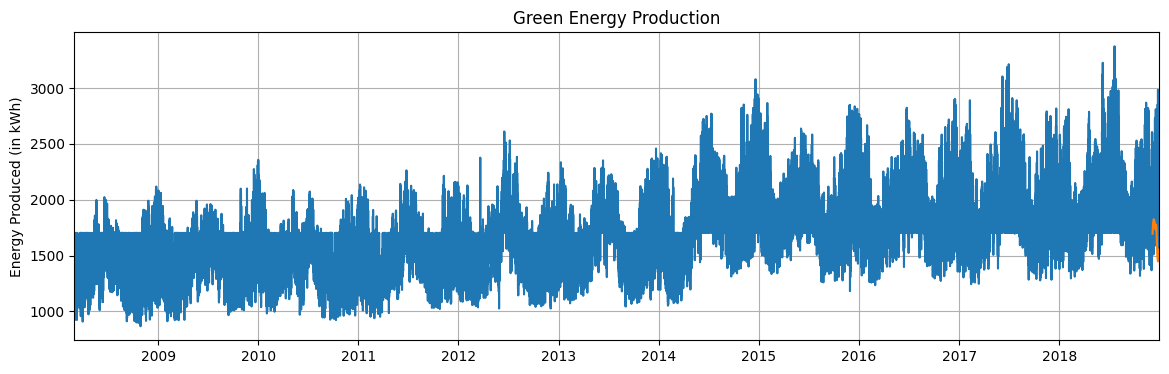

In [29]:
plt.figure(figsize=(14,4))
plt.title('Green Energy Production')
plt.ylabel('Energy Produced (in kWh)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['energy'])
plt.plot(x,true_predictions[-forecast:])
plt.show();

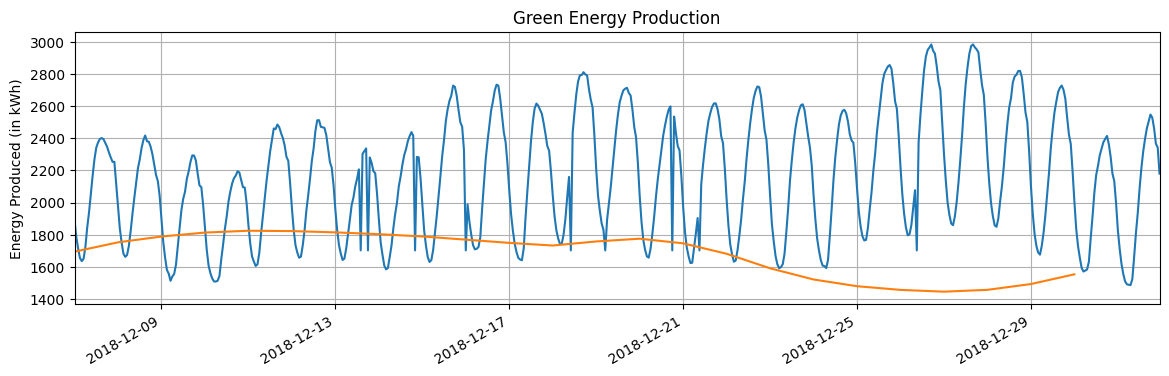

In [30]:
fig = plt.figure(figsize=(14,4))
plt.title('Green Energy Production')
plt.ylabel('Energy Produced (in kWh)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['energy']['2018-12-07':])
plt.plot(x,true_predictions[-forecast:])
plt.show();

## Training the model on entire data

In [31]:
start_time = time.time()

epochs = 25

y_norm = scaler.transform(np.array(y).reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = divide_data_into_batches(y_norm,window_size)

model.train()

for i in range(1,epochs+1):
    
    for seq, y_train in all_data:
        seq, y_train = seq.cuda(), y_train.cuda()
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                       torch.zeros(1,1,model.hidden_size,device='cuda'))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.004948406480252743
Epoch 2 -> Loss: 0.008339885622262955
Epoch 3 -> Loss: 0.009364664554595947
Epoch 4 -> Loss: 0.008479787968099117
Epoch 5 -> Loss: 0.00609207758679986
Epoch 6 -> Loss: 0.0011231048265472054
Epoch 7 -> Loss: 0.005273658316582441
Epoch 8 -> Loss: 0.0058448356576263905
Epoch 9 -> Loss: 0.0034330408088862896
Epoch 10 -> Loss: 0.0032004693057388067
Epoch 11 -> Loss: 0.0027879863046109676
Epoch 12 -> Loss: 0.0042619421146810055
Epoch 13 -> Loss: 0.0036986987106502056
Epoch 14 -> Loss: 0.006093249656260014
Epoch 15 -> Loss: 0.0007110819569788873
Epoch 16 -> Loss: 0.01149833481758833
Epoch 17 -> Loss: 9.495489211985841e-05
Epoch 18 -> Loss: 0.0008733381982892752
Epoch 19 -> Loss: 0.0049483017064630985
Epoch 20 -> Loss: 0.006821550894528627
Epoch 21 -> Loss: 0.0007068318082019687
Epoch 22 -> Loss: 0.00161503697745502
Epoch 23 -> Loss: 0.0021325726993381977
Epoch 24 -> Loss: 0.0017510721227154136
Epoch 25 -> Loss: 0.0041568698361516
Total time elapsed in LST

## Making forecast of energy production for 3 days

In [32]:
forecast = 36
predictions = y_norm[-window_size:].tolist()

model.eval()

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                       torch.zeros(1,1,model.hidden_size,device='cuda'))
        pred = model(seq)
        predictions.append(pred.item())

In [33]:
predictions[-36:]

[0.012749284505844116,
 -0.10355354845523834,
 -0.1898045688867569,
 -0.2506770193576813,
 -0.2661556303501129,
 -0.2701815664768219,
 -0.23000329732894897,
 -0.11242198944091797,
 -0.016061723232269287,
 0.07200497388839722,
 0.16450130939483643,
 0.23343920707702637,
 0.27004510164260864,
 0.27417778968811035,
 0.24218231439590454,
 0.17572951316833496,
 0.08018773794174194,
 -0.028196781873703003,
 -0.12543447315692902,
 -0.18652214109897614,
 -0.25143963098526,
 -0.28778064250946045,
 -0.2981705665588379,
 -0.2872854769229889,
 -0.23720094561576843,
 -0.16225823760032654,
 -0.09154646098613739,
 -0.051874369382858276,
 -0.01754102110862732,
 0.0011564791202545166,
 0.0009004771709442139,
 -0.0210493803024292,
 -0.06655991077423096,
 -0.121654212474823,
 -0.17460456490516663,
 -0.21882551908493042]

In [34]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions[-36:]

array([[1987.07457647],
       [1858.37643181],
       [1762.93295875],
       [1695.57285034],
       [1678.44456149],
       [1673.98954955],
       [1718.44993425],
       [1848.56281101],
       [1955.19295204],
       [2052.64561279],
       [2155.0000135 ],
       [2231.28516754],
       [2271.79244148],
       [2276.36558274],
       [2240.96009688],
       [2167.42489565],
       [2061.70047866],
       [1941.76456433],
       [1834.16348411],
       [1766.5652208 ],
       [1694.72896117],
       [1654.51480095],
       [1643.01754062],
       [1655.06274025],
       [1710.48517572],
       [1793.41512018],
       [1871.66320945],
       [1915.56346926],
       [1953.5559937 ],
       [1974.24623424],
       [1973.96294814],
       [1949.67372095],
       [1899.31277371],
       [1838.34663703],
       [1779.75294724],
       [1730.81901662]])

## Visualizing predictions on test data

In [35]:
x = np.arange('2018-12-31 23:00:00','2019-01-02 11:00:00',dtype='datetime64[h]')
x

array(['2018-12-31T23', '2019-01-01T00', '2019-01-01T01', '2019-01-01T02',
       '2019-01-01T03', '2019-01-01T04', '2019-01-01T05', '2019-01-01T06',
       '2019-01-01T07', '2019-01-01T08', '2019-01-01T09', '2019-01-01T10',
       '2019-01-01T11', '2019-01-01T12', '2019-01-01T13', '2019-01-01T14',
       '2019-01-01T15', '2019-01-01T16', '2019-01-01T17', '2019-01-01T18',
       '2019-01-01T19', '2019-01-01T20', '2019-01-01T21', '2019-01-01T22',
       '2019-01-01T23', '2019-01-02T00', '2019-01-02T01', '2019-01-02T02',
       '2019-01-02T03', '2019-01-02T04', '2019-01-02T05', '2019-01-02T06',
       '2019-01-02T07', '2019-01-02T08', '2019-01-02T09', '2019-01-02T10'],
      dtype='datetime64[h]')

In [36]:
len(x)

36

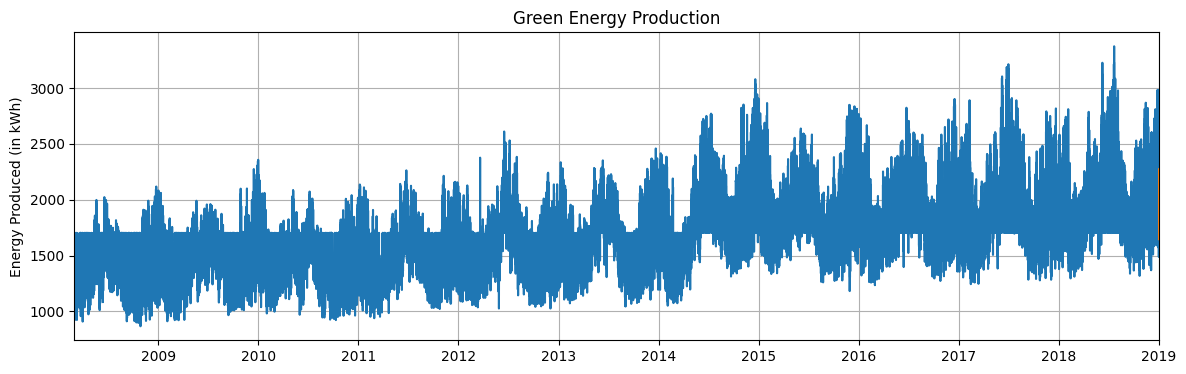

In [37]:
plt.figure(figsize=(14,4))
plt.title('Green Energy Production')
plt.ylabel('Energy Produced (in kWh)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['energy'])
plt.plot(x,true_predictions[-forecast:])
plt.show();

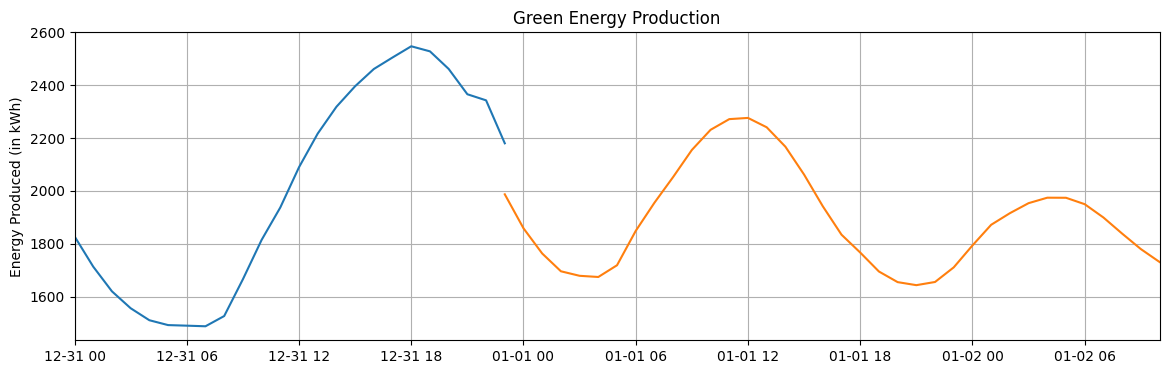

In [38]:
fig = plt.figure(figsize=(14,4))
plt.title('Green Energy Production')
plt.ylabel('Energy Produced (in kWh)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['energy']['2018-12-31':])
plt.plot(x,true_predictions[-36:])
plt.show();

## Loading test data

In [39]:
test_df = pd.read_csv("/kaggle/input/forecasting-green-energy/test_WudNWDM.csv",parse_dates=True,index_col='datetime')
test_df.head()

,row_id
datetime,
2019-01-01 00:00:00,94993
2019-01-01 01:00:00,94994
2019-01-01 02:00:00,94995
2019-01-01 03:00:00,94996
2019-01-01 04:00:00,94997


In [40]:
test_df.shape

(26304, 1)

## Forecasting on test data

In [41]:
forecast = 26304
predictions = y_norm[-window_size:].tolist()

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()  
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                       torch.zeros(1,1,model.hidden_size,device='cuda'))
        pred = model(seq)
        predictions.append(pred.item())

In [42]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

## Visualizing the predictions

In [43]:
x = np.arange('2018-12-31','2021-12-31',dtype='datetime64[h]')
len(x)

26304

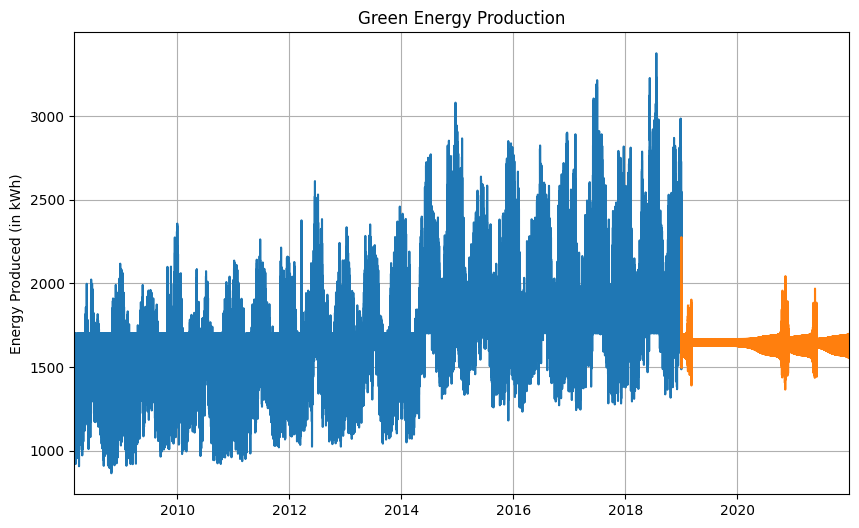

In [44]:
plt.figure(figsize=(10,6))
plt.title('Green Energy Production')
plt.ylabel('Energy Produced (in kWh)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['energy'])
plt.plot(x,true_predictions[window_size:])
plt.show();

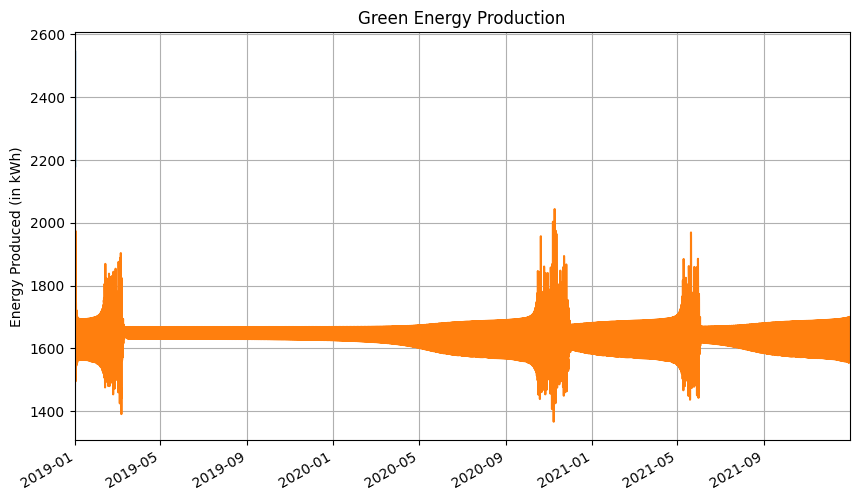

In [45]:
fig = plt.figure(figsize=(10,6))
plt.title('Green Energy Production')
plt.ylabel('Energy Produced (in kWh)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['energy']['2018-12-31':])
plt.plot(x,true_predictions[window_size:])
plt.show();

In [46]:
len(true_predictions[window_size:])

26304

In [47]:
true_predictions[window_size:]

array([[1987.07457647],
       [1858.37643181],
       [1762.93295875],
       ...,
       [1687.89487364],
       [1688.90942703],
       [1692.44087352]])

In [48]:
test_df.row_id.values.shape

(26304,)

In [49]:
np.array(true_predictions[window_size:]).flatten().shape

(26304,)

## Saving the model for future use

In [50]:
torch.save(model,'green_energy_forecaster.pt')

## Converting the final forecasts into a resultant dataframe

In [51]:
res_df = pd.DataFrame({'row_id': test_df.row_id.values, 'energy': np.array(true_predictions[window_size:]).flatten()})
res_df.head()

,row_id,energy
0,94993,1987.074576
1,94994,1858.376432
2,94995,1762.932959
3,94996,1695.572850
4,94997,1678.444561


In [52]:
res_df.to_csv("final_submission_file.csv")